In [2]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import metrics

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, Sequential
from tensorflow.keras import models, layers, optimizers, regularizers
# from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
import splitfolders

import cv2

import os

For this final model we'll be using the full 8Gb Mendeley dataset. The ratio has 65% train, 15% validate, 20% test.

splitfolders.ratio("./data/combined/", output="combined_ttv", seed=42, ratio=(.65, .15, .2), group_prefix=None, move=True)

In [3]:
splitfolders.ratio("./data/Mendeleycombined/", output="mendeley_combined_ttv", seed=42, ratio=(.65, .15, .2), group_prefix=None, move=True)

Copying files: 5856 files [00:04, 1337.43 files/s]


In [2]:
# Get photos for model training
# train = tf.keras.utils.image_dataset_from_directory('./data/archive/chest_xray/chest_xray/train')
# test = tf.keras.utils.image_dataset_from_directory('./data/archive/chest_xray/chest_xray/test')
# val = tf.keras.utils.image_dataset_from_directory('./data/archive/chest_xray/chest_xray/val')

In [3]:
def Get_Photo_Data(location, num_photos):
    '''
    Returns photos from data folder(resized, grayscaled) and binary class.
    
    '''
    datagen = ImageDataGenerator(rescale=1./255)
    
    data = datagen.flow_from_directory(
        location,
        target_size=(150, 150),
        batch_size=num_photos,
        color_mode='grayscale',
        class_mode='binary'
    )
    
    return data

In [4]:
#getting images and labels for models
train_photos = Get_Photo_Data('./combined_ttv/train/', 3805)
test_photos = Get_Photo_Data('./combined_ttv/test/', 1174)
val_photos = Get_Photo_Data('./combined_ttv/val/', 877)

Found 3805 images belonging to 2 classes.
Found 1174 images belonging to 2 classes.
Found 877 images belonging to 2 classes.


In [5]:
# unpack images and labels for CM/dummy model
train_data, train_labels = next (train_photos)
test_data, test_labels = next (test_photos)
val_data, val_labels = next (val_photos)

# Model 7
For this model we made the following changes:
1. Combine and resplit train/test/validate to get more suitable numbers for each.


In [6]:
model = Sequential()

In [7]:
# Add layers to model
# input layer

model.add(Conv2D(64, (3,3), 1, activation='relu', padding = 'same', input_shape=(150,150,1)))

# add pooling layer(takes max from input window)
model.add(layers.MaxPooling2D((2,2)))

model.add(Conv2D(32, (3,3), 1, activation='relu', padding = 'same'))

# add pooling layer(takes max from input window)
model.add(layers.MaxPooling2D((2,2)))

# flattens 2d to 1d
model.add(layers.Flatten())

# add dense layer
model.add(layers.Dense(16, activation='relu'))

model.add(Dropout(0.15))

# add output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [8]:
# compile model with adam for binary model
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy',
                                                                    Precision(name='precision'),
                                                                    Recall(name='recall')])

In [9]:
# fit model
history = model.fit(train_data,
               train_labels,
               batch_size=30,
               epochs=10,
               validation_data=(val_data, val_labels))

Epoch 1/10
127/127 [==============================] - 41s 271ms/step - loss: 0.3755 - accuracy: 0.8294 - precision: 0.8176 - recall: 0.9863 - val_loss: 0.2795 - val_accuracy: 0.9190 - val_precision: 0.9141 - val_recall: 0.9812
Epoch 2/10
127/127 [==============================] - 64s 503ms/step - loss: 0.2779 - accuracy: 0.9159 - precision: 0.9177 - recall: 0.9719 - val_loss: 0.2414 - val_accuracy: 0.9373 - val_precision: 0.9372 - val_recall: 0.9797
Epoch 3/10
127/127 [==============================] - 54s 432ms/step - loss: 0.2477 - accuracy: 0.9377 - precision: 0.9462 - recall: 0.9698 - val_loss: 0.2259 - val_accuracy: 0.9430 - val_precision: 0.9403 - val_recall: 0.9844
Epoch 4/10
127/127 [==============================] - 28s 221ms/step - loss: 0.2310 - accuracy: 0.9456 - precision: 0.9531 - recall: 0.9734 - val_loss: 0.2143 - val_accuracy: 0.9430 - val_precision: 0.9483 - val_recall: 0.9750
Epoch 5/10
127/127 [==============================] - 14s 112ms/step - loss: 0.2087 - accura

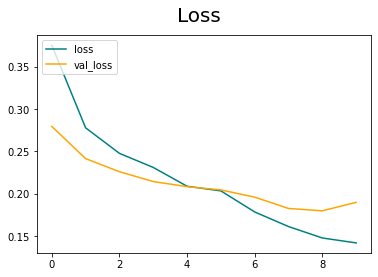

In [10]:
# examine loss of model across epochs
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

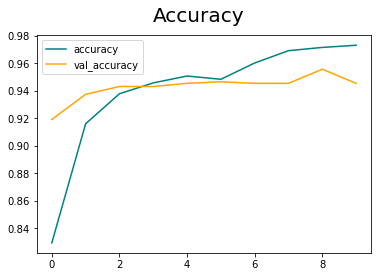

In [11]:
# examine accuracy of model across epochs
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [12]:
results=model.evaluate(test_data, test_labels)

37/37 [==============================] - 1s 29ms/step - loss: 0.1995 - accuracy: 0.9523 - precision: 0.9556 - recall: 0.9801


In [13]:
print(f"Model loss:  {results[0]}")
print(f"Model accuracy: {results[1]}")
print(f"Model precision: {results[2]}")
print(f"Model recall: {results[3]}")

Model loss:  0.199452206492424
Model accuracy: 0.9522998332977295
Model precision: 0.9555808901786804
Model recall: 0.980140209197998


### Model 7 summary
Performance metrics for model 7 are much better than all previous models. By using a recombined dataset to get more balanced train/test/split, we're able to get much better scores with an identical model.

Compared to our dummy model, we have increased performance across all metrics(Recall is the same):
<br> ----------------Precision-----Accuracy-----Recall
<br> DUMMY------0.63----------0.63-------------1
<br> FSM,3,4,5,6----0.71----------0.74---------0.98
<br> MODEL2-----0.63----------0.63-------------1
<br> MODEL7-----0.96----------0.95---------0.98

### Next steps
Next, we'll go ahead and use this same model design on the full 8gb dataset from Mendelay.